# Autoencoder

## 1. Settings

### 1) Import required libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib as mpl

### 2) Set hyperparameters

In [2]:
batch_size = 256
learning_rate = 0.0002
num_epochs = 10

## 2. Data

### 1) Download Data

In [3]:
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000])

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
mnist_train[0][0].size()    # (1, 28, 28)

torch.Size([1, 28, 28])

In [5]:
mnist_train[0][1]           # label

1

### 2) Set DataLoader

In [6]:
dataloaders = {}
dataloaders['train'] = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
dataloaders['val'] = DataLoader(mnist_val, batch_size=batch_size, shuffle=False)
dataloaders['test'] = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [7]:
len(dataloaders["train"])

196

## 3. Model & Optimizer

### 1) Model

In [8]:
# build your own autoencoder
# in my case: 784(28*28) -> 100 -> 30 -> 100 -> 784(28*28)

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 100),    
            nn.ReLU(),                          # activation function
            nn.Linear(100, 30),
            nn.ReLU()                           # activation function
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(30, 100),
            nn.ReLU(),                          # activation function
            nn.Linear(100, 784),
            nn.ReLU()                           # activation function
        )

                
    def forward(self, x):                # x: (batch_size, 1, 28, 28)
        batch_size = x.size(0)
        x = x.reshape(-1, 784)                          # reshape to 784(28*28)-dimensional vector
        encoded = self.encoder(x)                    # hidden vector
        out = self.decoder(encoded).reshape(batch_size, 1, 28, 28)                        # final output. resize to input's size
        return out, encoded


### 2) Loss func & Optimizer

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
model = Autoencoder().to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## 4. Train 

In [11]:
import time
import copy

def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    """
    model: model to train
    dataloaders: train, val, test data's loader
    criterion: loss function
    optimizer: optimizer to update your model
    """
    since = time.time()

    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = 100000000

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()            # Set model to training mode
            else:
                model.eval()            # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs=inputs.to(device)                                       # transfer inputs to GPU 

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    outputs, encoded = model(inputs)
                    loss = criterion(outputs, inputs)                          # calculate a loss


                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()                             # perform back-propagation from the loss
                        optimizer.step()                             # perform gradient descent with given optimizer

                # statistics
                running_loss += loss.item() * inputs.size(0)                    

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            
            # deep copy the model
            if phase == 'train':
                train_loss_history.append(epoch_loss)
            
            if phase == 'val':
                val_loss_history.append(epoch_loss)

            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                
            
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_val_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history

In [12]:
best_model, train_loss_history, val_loss_history = train_model(model, dataloaders, loss_func, optimizer, num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 0.0747
val Loss: 0.0521

Epoch 1/9
----------
train Loss: 0.0420
val Loss: 0.0360

Epoch 2/9
----------
train Loss: 0.0328
val Loss: 0.0307

Epoch 3/9
----------
train Loss: 0.0291
val Loss: 0.0281

Epoch 4/9
----------
train Loss: 0.0270
val Loss: 0.0265

Epoch 5/9
----------
train Loss: 0.0256
val Loss: 0.0253

Epoch 6/9
----------
train Loss: 0.0246
val Loss: 0.0242

Epoch 7/9
----------
train Loss: 0.0236
val Loss: 0.0234

Epoch 8/9
----------
train Loss: 0.0230
val Loss: 0.0230

Epoch 9/9
----------
train Loss: 0.0226
val Loss: 0.0227

Training complete in 0m 46s
Best val Loss: 0.022663


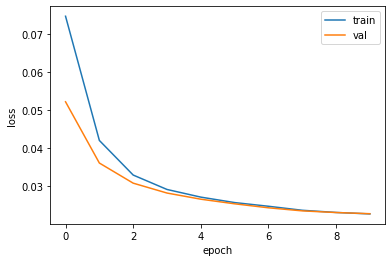

In [15]:
# Let's draw a learning curve like below.
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

## 5. Check with Test Image

In [16]:
with torch.no_grad():
    running_loss = 0.0
    for inputs, labels in dataloaders["test"]:
        inputs = inputs.to(device)

        outputs, encoded = best_model(inputs)
        test_loss = loss_func(outputs, inputs)
        
        running_loss += test_loss.item() * inputs.size(0)

    test_loss = running_loss / len(dataloaders["test"].dataset)
    print(test_loss)        

0.022204350179433823


torch.Size([16, 28, 28])


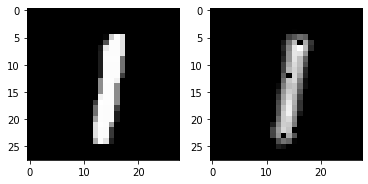

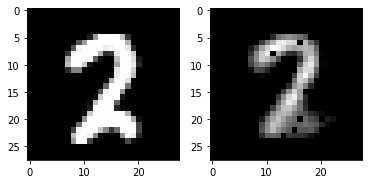

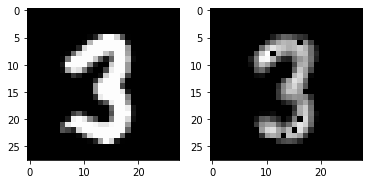

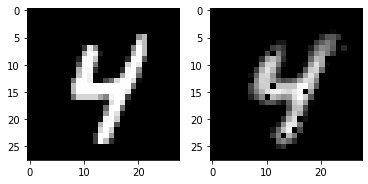

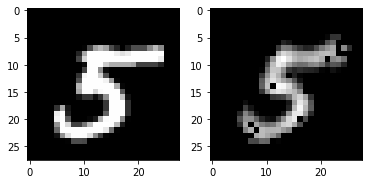

In [17]:
out_img = torch.squeeze(outputs.cpu().data)
print(out_img.size())

for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(inputs[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()

## 6. Visualizing MNIST

In [18]:
np.random.seed(42)

from sklearn.manifold import TSNE

In [19]:
test_dataset_array = mnist_test.data.numpy() / 255
test_dataset_array = np.float32(test_dataset_array)
labels = mnist_test.targets.numpy()

In [20]:
test_dataset_array = torch.tensor(test_dataset_array)
inputs = test_dataset_array.to(device)
outputs, encoded = best_model(inputs)

In [21]:
encoded = encoded.cpu().detach().numpy()
tsne = TSNE()   
X_test_2D = tsne.fit_transform(encoded)
X_test_2D = (X_test_2D - X_test_2D.min()) / (X_test_2D.max() - X_test_2D.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


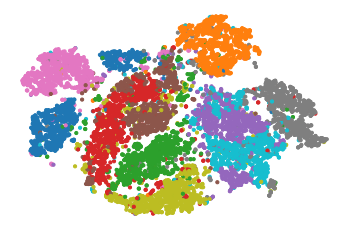

In [22]:
plt.scatter(X_test_2D[:, 0], X_test_2D[:, 1], c=labels, s=10, cmap="tab10")
plt.axis("off")
plt.show()

Let's make this diagram a bit prettier:

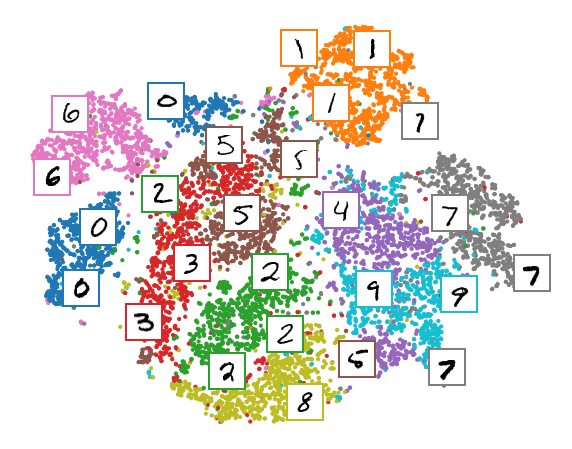

In [23]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_test_2D[:, 0], X_test_2D[:, 1], c=labels, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_test_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(torch.squeeze(inputs).cpu().numpy()[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(labels[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

# Denoising Autoencoder

In [24]:
model_D = Autoencoder().to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model_D.parameters(), lr=learning_rate)

In [25]:
# It's all the same except for one: adding noise to inputs
# copy train_model() code and just add 'noise part'
# Hint: You can make noise like this.
# noise = torch.zeros(inputs.size(0), 1, 28, 28)
# nn.init.normal_(noise, 0, 0.1)

def train_model_D(model, dataloaders, criterion, optimizer, num_epochs=10):

    since = time.time()

    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = 100000000

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()            # Set model to training mode
            else:
                model.eval()            # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                noise = torch.zeros(inputs.size(0), 1, 28, 28)
                nn.init.normal_(noise, 0, 0.1)
                noise=noise.to(device)
                inputs=inputs.to(device)                                       # transfer inputs to GPU 
                noise_inputs=inputs+noise

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    outputs, encoded = model(noise_inputs)
                    loss = criterion(outputs, inputs)                          # calculate a loss


                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()                             # perform back-propagation from the loss
                        optimizer.step()                             # perform gradient descent with given optimizer

                # statistics
                running_loss += loss.item() * inputs.size(0)                    

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            
            # deep copy the model
            if phase == 'train':
                train_loss_history.append(epoch_loss)
            
            if phase == 'val':
                val_loss_history.append(epoch_loss)

            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                
            
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_val_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, train_loss_history, val_loss_history

In [26]:
best_model_D, train_loss_history_D, val_loss_history_D = train_model_D(model_D, dataloaders, loss_func, optimizer, num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 0.0753
val Loss: 0.0523

Epoch 1/9
----------
train Loss: 0.0418
val Loss: 0.0354

Epoch 2/9
----------
train Loss: 0.0323
val Loss: 0.0301

Epoch 3/9
----------
train Loss: 0.0285
val Loss: 0.0275

Epoch 4/9
----------
train Loss: 0.0265
val Loss: 0.0259

Epoch 5/9
----------
train Loss: 0.0248
val Loss: 0.0244

Epoch 6/9
----------
train Loss: 0.0238
val Loss: 0.0235

Epoch 7/9
----------
train Loss: 0.0230
val Loss: 0.0228

Epoch 8/9
----------
train Loss: 0.0224
val Loss: 0.0223

Epoch 9/9
----------
train Loss: 0.0220
val Loss: 0.0219

Training complete in 0m 51s
Best val Loss: 0.021902


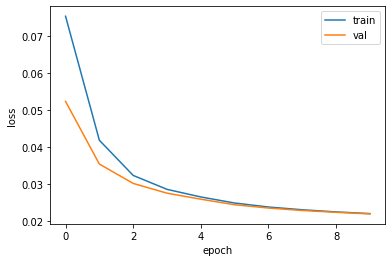

In [27]:
plt.plot(train_loss_history_D, label='train')
plt.plot(val_loss_history_D, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [28]:
with torch.no_grad():
  running_loss = 0.0
  for inputs, labels in dataloaders['test']:
      noise = nn.init.normal_(torch.FloatTensor(inputs.size(0), 1, 28, 28), 0, 0.1)
      noise = noise.to(device)
      inputs = inputs.to(device)
      noise_inputs = inputs + noise

      outputs, encoded = best_model_D(noise_inputs)
      test_loss = loss_func(outputs, inputs)
      
      running_loss += test_loss.item()* inputs.size(0)

  test_loss = running_loss / len(dataloaders['test'].dataset)
  print(test_loss) 

0.021566521868109704


torch.Size([16, 28, 28])


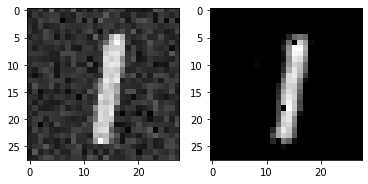

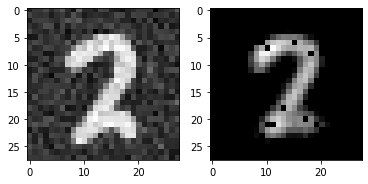

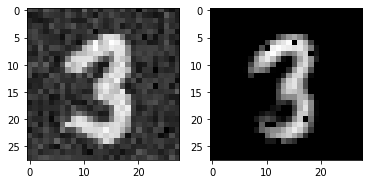

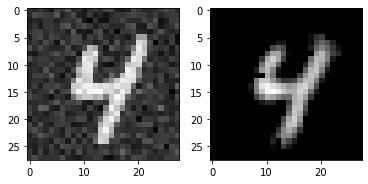

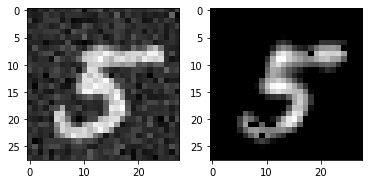

In [29]:
out_img = torch.squeeze(outputs.cpu().data)
print(out_img.size())

for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(noise_inputs[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()